# Guide
Same cells like las notebook but here only use the three providers that are availables now to have a good model to predict the current demand.

# Preconfiguration
To execute - First create a service account and save in Google Drive, after change next data

In [2]:
#Modify after MyDrive providing folders and file name
service_account_location = "drive/MyDrive/Ideas/movilidad/vacio-276411-service_account_for_colab.json"

#Imports

In [3]:
pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.3 MB/s 


In [4]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.3 MB 35.1 MB/s 
     |████████████████████████████████| 16.7 MB 342 kB/s 


In [5]:
#Pandas import
import pandas as pd
#Numpy import
import numpy as np
#Seaborn import
import seaborn as sns
#Geospatial imports
import matplotlib.pyplot as plt
import geopandas as gpd
#Import KMZ
import fiona
#Forecast time series
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
#Import for autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#Import for arima model
from statsmodels.tsa.arima_model import ARIMA
#BIGQUERY IMPORTS
from google.cloud import bigquery #For bigquerycredentials
from google.oauth2 import service_account #For credentials


##Mount access to Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

#Set credentials as global
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= service_account_location

# Construct a BigQuery client object.
client = bigquery.Client()

Mounted at /content/drive


# Get data

In [6]:
query = """
SELECT * FROM `vacio-276411.mainDataset.V1_trips_grouped_all_hours_onlythree`
"""
df_tripsa_grouped = client.query(query).to_dataframe()

In [7]:
df_tripsa_grouped

,district,dateandtime,trips
0,1,2021-05-04 00:00:00+00:00,0
1,1,2021-05-04 01:00:00+00:00,2
2,1,2021-05-04 02:00:00+00:00,0
3,1,2021-05-04 03:00:00+00:00,4
4,1,2021-05-04 04:00:00+00:00,2
...,...,...,...
104755,9,2022-08-31 19:00:00+00:00,0
104756,9,2022-08-31 20:00:00+00:00,0
104757,9,2022-08-31 21:00:00+00:00,0
104758,9,2022-08-31 22:00:00+00:00,0


In [8]:
df_tripsa_grouped.reset_index(drop=True)

,district,dateandtime,trips
0,1,2021-05-04 00:00:00+00:00,0
1,1,2021-05-04 01:00:00+00:00,2
2,1,2021-05-04 02:00:00+00:00,0
3,1,2021-05-04 03:00:00+00:00,4
4,1,2021-05-04 04:00:00+00:00,2
...,...,...,...
104755,9,2022-08-31 19:00:00+00:00,0
104756,9,2022-08-31 20:00:00+00:00,0
104757,9,2022-08-31 21:00:00+00:00,0
104758,9,2022-08-31 22:00:00+00:00,0


# Timeseries

Create lag

In [9]:
#Shift method to create the lag variables
df_tripsa_grouped['trips_lag_28_days'] = df_tripsa_grouped['trips'].shift(28*24) #28 days before same hour
df_tripsa_grouped['trips_lag_14_days'] = df_tripsa_grouped['trips'].shift(14*24) #14 days before same hour
df_tripsa_grouped['trips_lag_7_days'] = df_tripsa_grouped['trips'].shift(7*24) #7 days before same hour
df_tripsa_grouped['trips_lag_1_days'] = df_tripsa_grouped['trips'].shift(1*24) # 1 day before same hour
df_tripsa_grouped['trips_lag_2_days'] = df_tripsa_grouped['trips'].shift(2*24) # 2 days before same hour
df_tripsa_grouped['trips_lag_1_hours'] = df_tripsa_grouped['trips'].shift(1) # 1 hour before
df_tripsa_grouped['trips_lag_2_hours'] = df_tripsa_grouped['trips'].shift(1) # 2 hours before
df_tripsa_grouped

,district,dateandtime,trips,trips_lag_28_days,trips_lag_14_days,trips_lag_7_days,trips_lag_1_days,trips_lag_2_days,trips_lag_1_hours,trips_lag_2_hours
0,1,2021-05-04 00:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2021-05-04 01:00:00+00:00,2,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,1,2021-05-04 02:00:00+00:00,0,NaN,NaN,NaN,NaN,NaN,2.0,2.0
3,1,2021-05-04 03:00:00+00:00,4,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,1,2021-05-04 04:00:00+00:00,2,NaN,NaN,NaN,NaN,NaN,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...
104755,9,2022-08-31 19:00:00+00:00,0,16.0,0.0,5.0,13.0,4.0,0.0,0.0
104756,9,2022-08-31 20:00:00+00:00,0,5.0,0.0,8.0,8.0,3.0,0.0,0.0
104757,9,2022-08-31 21:00:00+00:00,0,4.0,0.0,8.0,5.0,4.0,0.0,0.0
104758,9,2022-08-31 22:00:00+00:00,0,5.0,0.0,2.0,2.0,6.0,0.0,0.0


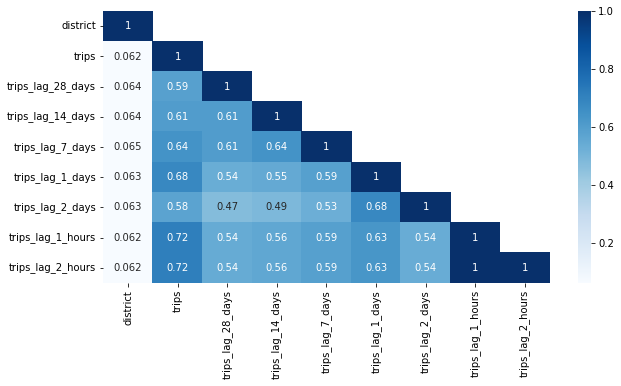

In [10]:
corr_matrix = df_tripsa_grouped.corr()
fig = plt.figure(figsize=(10, 5))

mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False

sns.heatmap(corr_matrix, mask = mask, annot=True, cbar=True,cmap="Blues")
plt.show()

Evaluation metric

In [11]:
def mape(y_true, y_pred):
    ape = np.abs((y_true - y_pred) / y_true)
    #ape[~np.isfinite(ape)] = 0. # VERY questionable
    ape[~np.isfinite(ape)] = 1. # pessimist estimate
    return np.mean(ape)

def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

Baseline

In [12]:
y_pred = df_tripsa_grouped['trips']
y_true = df_tripsa_grouped['trips_lag_1_hours']

In [13]:
result_1 = {'Method':['Baseline'],'MAPE':[mape(y_true, y_pred)],'WMAPE':[wmape(y_true, y_pred)]}
df_results = pd.DataFrame(result_1)
df_results

,Method,MAPE,WMAPE
0,Baseline,0.722025,0.441201


Spit data

In [14]:
#Split data
#TODO: Without change this date in the future the test list will be bigger than now
#split_point = 40
#TODO: Remove august becouse is not ready
df_tripsa_grouped_original = df_tripsa_grouped.copy()
df_tripsa_grouped =  df_tripsa_grouped[df_tripsa_grouped['dateandtime'] < '2022-06-01']

split_point = '2022-05-01'
filter_train = df_tripsa_grouped['dateandtime'] < split_point
filter_valid = df_tripsa_grouped['dateandtime'] >= split_point

df_all_hours_data_train = df_tripsa_grouped[ filter_train].copy()
df_all_hours_data_valid = df_tripsa_grouped[ filter_valid ].copy()

Train model

In [15]:
features= ['trips_lag_28_days',	'trips_lag_14_days',	'trips_lag_7_days',	'trips_lag_1_days',	'trips_lag_2_days',	'trips_lag_1_hours',	'trips_lag_2_hours']

imputer = SimpleImputer()
Xtr = imputer.fit_transform(df_all_hours_data_train[features])
ytr = df_all_hours_data_train['trips']

mdl = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6)
mdl.fit(Xtr, ytr)

RandomForestRegressor(n_jobs=6, random_state=0)

Evaluate model

In [16]:
Xval = imputer.transform(df_all_hours_data_valid[features])
yval = df_all_hours_data_valid['trips']

p = mdl.predict(Xval)

In [17]:
p

array([1.4645    , 4.21141667, 0.825     , ..., 1.99      , 5.97      ,
       1.41      ])

In [18]:
result_2 = {'Method':'RandomForest_1','MAPE':mape(yval,p),'WMAPE':wmape(yval, p)}
df_results = df_results.append(result_2, ignore_index = True)
df_results

,Method,MAPE,WMAPE
0,Baseline,0.722025,0.441201
1,RandomForest_1,0.526642,0.332084


Check district 4 and draw result

In [19]:
filter_district_df_all_hours_data_train = df_all_hours_data_train['district'] == 1
filter_district_df_all_hours_data_valid = df_all_hours_data_valid['district'] == 1
filter_district_df_tripsa_grouped = df_tripsa_grouped['district'] == 1

Xval = imputer.transform(df_all_hours_data_valid[filter_district_df_all_hours_data_valid][features])
yval = df_all_hours_data_valid[filter_district_df_all_hours_data_valid]['trips']

p = mdl.predict(Xval)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


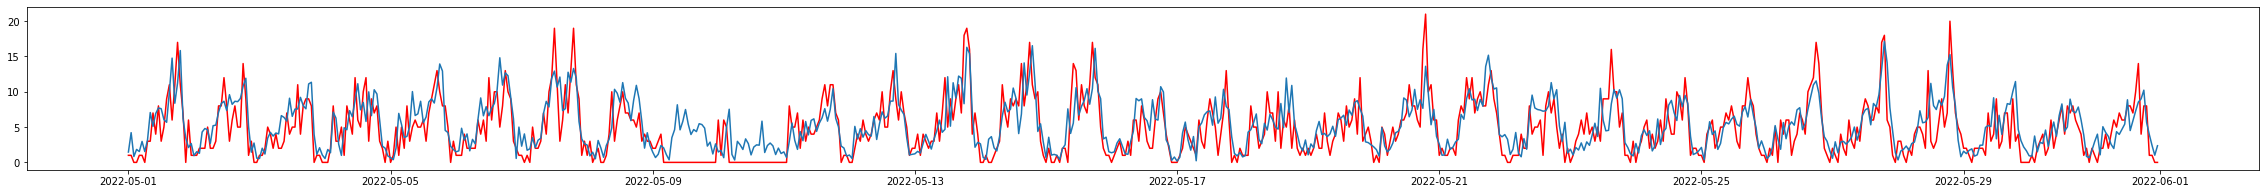

In [20]:
fig, ax = plt.subplots(figsize=(40, 3))

#Original
xpoints = df_tripsa_grouped[filter_valid][filter_district_df_tripsa_grouped]['dateandtime']
yReal= df_tripsa_grouped[filter_valid][filter_district_df_tripsa_grouped]['trips']

#Predicted
ypoints = df_all_hours_data_valid[filter_district_df_all_hours_data_valid]['dateandtime']
yEstimation = p

plt.plot(xpoints, yReal, c='red')
plt.plot(ypoints, yEstimation)
plt.show()

In [21]:
print('Mape for district 4' , mape(yval,p) , 'WMAPE:', wmape(yval, p), ' Mean trips: ', df_tripsa_grouped[filter_valid]["trips"].mean(), ' WMAPE percent:', wmape(yval, p)/df_tripsa_grouped[filter_valid]["trips"].mean())

Mape for district 4 0.6935259772287501 WMAPE: 0.48268742868374576  Mean trips:  11.301373954599761  WMAPE percent: 0.04271050852956579


# Train a specific time series 
Train a specifict time series for this district to compare if the results could be better with a serie for every district instead of one for all

In [22]:
#Train model
features= ['trips_lag_28_days',	'trips_lag_14_days',	'trips_lag_7_days',	'trips_lag_1_days',	'trips_lag_2_days',	'trips_lag_1_hours',	'trips_lag_2_hours']

imputer = SimpleImputer()
Xtr = imputer.fit_transform(df_all_hours_data_train[filter_district_df_all_hours_data_train][features])
ytr = df_all_hours_data_train[filter_district_df_all_hours_data_train]['trips']

mdl2 = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6)
mdl2.fit(Xtr, ytr)
#Evaluate model

Xval = imputer.transform(df_all_hours_data_valid[filter_district_df_all_hours_data_valid][features])
yval = df_all_hours_data_valid[filter_district_df_all_hours_data_valid]['trips']

p = mdl2.predict(Xval)
print('Mape for district 1' , mape(yval,p) , 'WMAPE:', wmape(yval, p), ' Mean trips: ', df_tripsa_grouped[filter_valid]["trips"].mean(), ' WMAPE percent:', wmape(yval, p)/df_tripsa_grouped[filter_valid]["trips"].mean())

Mape for district 1 0.6567815918193896 WMAPE: 0.48676280225538154  Mean trips:  11.301373954599761  WMAPE percent: 0.043071117212015154


In [23]:
#Calculate error
result_3 = {'Method':'RandomForest_1_DISC_1','MAPE':mape(yval,p),'WMAPE':wmape(yval, p)}
df_results = df_results.append(result_3, ignore_index = True)
df_results

,Method,MAPE,WMAPE
0,Baseline,0.722025,0.441201
1,RandomForest_1,0.526642,0.332084
2,RandomForest_1_DISC_1,0.656782,0.486763


# Test
Test manual para comprobar calidad de los datos

In [24]:
df_test = df_tripsa_grouped_original[ (df_tripsa_grouped_original['dateandtime'] > '2022-06-01') & (df_tripsa_grouped_original['dateandtime'] < '2022-06-30')  ]
df_test

,district,dateandtime,trips,trips_lag_28_days,trips_lag_14_days,trips_lag_7_days,trips_lag_1_days,trips_lag_2_days,trips_lag_1_hours,trips_lag_2_hours
9433,1,2022-06-01 01:00:00+00:00,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9434,1,2022-06-01 02:00:00+00:00,2,2.0,1.0,4.0,2.0,0.0,3.0,3.0
9435,1,2022-06-01 03:00:00+00:00,4,8.0,8.0,5.0,2.0,2.0,2.0,2.0
9436,1,2022-06-01 04:00:00+00:00,5,3.0,5.0,6.0,4.0,3.0,4.0,4.0
9437,1,2022-06-01 05:00:00+00:00,9,3.0,5.0,2.0,2.0,4.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...
103243,9,2022-06-29 19:00:00+00:00,11,5.0,5.0,18.0,16.0,9.0,12.0,12.0
103244,9,2022-06-29 20:00:00+00:00,14,7.0,7.0,9.0,8.0,8.0,11.0,11.0
103245,9,2022-06-29 21:00:00+00:00,11,11.0,4.0,8.0,5.0,2.0,14.0,14.0
103246,9,2022-06-29 22:00:00+00:00,2,8.0,2.0,1.0,1.0,1.0,11.0,11.0


In [25]:
Xval = imputer.transform(df_test[features])
yval = df_test['trips']

p = mdl.predict(Xval)

In [26]:
df_test = df_test.assign(prediction = p)
df_test[['trips','prediction']]

,trips,prediction
9433,3,0.995580
9434,2,1.318333
9435,4,5.710000
9436,5,3.875000
9437,9,2.880000
...,...,...
103243,11,13.160000
103244,14,7.950667
103245,11,8.640000
103246,2,4.763333


In [27]:
df_test['desviacion'] = abs(df_test['trips'] - df_test['prediction'])
df_test

,district,dateandtime,trips,trips_lag_28_days,trips_lag_14_days,trips_lag_7_days,trips_lag_1_days,trips_lag_2_days,trips_lag_1_hours,trips_lag_2_hours,prediction,desviacion
9433,1,2022-06-01 01:00:00+00:00,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.995580,2.004420
9434,1,2022-06-01 02:00:00+00:00,2,2.0,1.0,4.0,2.0,0.0,3.0,3.0,1.318333,0.681667
9435,1,2022-06-01 03:00:00+00:00,4,8.0,8.0,5.0,2.0,2.0,2.0,2.0,5.710000,1.710000
9436,1,2022-06-01 04:00:00+00:00,5,3.0,5.0,6.0,4.0,3.0,4.0,4.0,3.875000,1.125000
9437,1,2022-06-01 05:00:00+00:00,9,3.0,5.0,2.0,2.0,4.0,5.0,5.0,2.880000,6.120000
...,...,...,...,...,...,...,...,...,...,...,...,...
103243,9,2022-06-29 19:00:00+00:00,11,5.0,5.0,18.0,16.0,9.0,12.0,12.0,13.160000,2.160000
103244,9,2022-06-29 20:00:00+00:00,14,7.0,7.0,9.0,8.0,8.0,11.0,11.0,7.950667,6.049333
103245,9,2022-06-29 21:00:00+00:00,11,11.0,4.0,8.0,5.0,2.0,14.0,14.0,8.640000,2.360000
103246,9,2022-06-29 22:00:00+00:00,2,8.0,2.0,1.0,1.0,1.0,11.0,11.0,4.763333,2.763333


In [28]:
df_test_error = df_test.groupby('trips')['desviacion'].mean().reset_index()
df_test_error

,trips,desviacion
0,0,3.584813
1,1,2.030590
2,2,2.060519
3,3,2.459036
4,4,2.751971
...,...,...
62,63,59.280000
63,66,33.420000
64,67,8.310000
65,69,23.570000


In [29]:
df_test_error['fallo'] = df_test_error['desviacion'] / df_test_error['trips']
df_test_error

,trips,desviacion,fallo
0,0,3.584813,inf
1,1,2.030590,2.030590
2,2,2.060519,1.030260
3,3,2.459036,0.819679
4,4,2.751971,0.687993
...,...,...,...
62,63,59.280000,0.940952
63,66,33.420000,0.506364
64,67,8.310000,0.124030
65,69,23.570000,0.341594


In [30]:
#Marco como aceptable un desajuste de viajes en un 15%
df_test_error['aceptable'] = df_test_error['fallo'] < 0.15
df_test_error

,trips,desviacion,fallo,aceptable
0,0,3.584813,inf,False
1,1,2.030590,2.030590,False
2,2,2.060519,1.030260,False
3,3,2.459036,0.819679,False
4,4,2.751971,0.687993,False
...,...,...,...,...
62,63,59.280000,0.940952,False
63,66,33.420000,0.506364,False
64,67,8.310000,0.124030,True
65,69,23.570000,0.341594,False


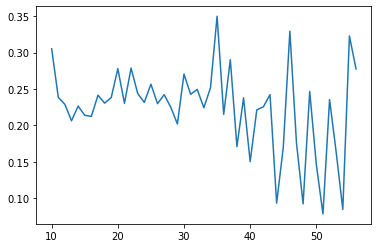

In [31]:
#import matplotlib.pyplot as plt
#import numpy as np

xpoints = np.array([1, 2, 6, 8])
ypoints = np.array([3, 8, 1, 10])

#Remove first and las 10 to not lose the data size of the plot
plt.plot(df_test_error['trips'][10:-10], df_test_error['fallo'][10:-10] )
plt.show()

Vemos la cantidad de datos por cantida de viajes para ver si los mayores de 40 son reseñables


In [32]:
df_tmp= df_test.groupby('trips').size().reset_index()
df_tmp

,trips,0
0,0,216
1,1,304
2,2,389
3,3,354
4,4,377
...,...,...
62,63,1
63,66,1
64,67,2
65,69,1


In [33]:
df_tmp[0]

0     216
1     304
2     389
3     354
4     377
     ... 
62      1
63      1
64      2
65      1
66      1
Name: 0, Length: 67, dtype: int64

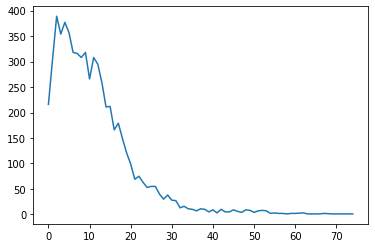

In [34]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = df_tmp['trips']
ypoints = df_tmp[0]

plt.plot(xpoints, ypoints)
plt.show()

In [35]:
df_tmp[0][40:]

40     9
41     3
42    10
43     5
44     5
45     9
46     6
47     4
48     9
49     8
50     4
51     7
52     8
53     7
54     2
55     3
56     2
57     2
58     1
59     2
60     2
61     3
62     1
63     1
64     2
65     1
66     1
Name: 0, dtype: int64

Podemos ver que a partir del 40 hay muy pocos viajes por lo que no tenemos que considerar el error. En la grafica superior vemos que el eror medio es de 0.3

# Export model

In [ ]:
import joblib
joblib.dump(mdl, 'my_model.pkl', compress=9)

['my_model.pkl']

In [ ]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


In [ ]:
df_test.head(10)